<a href="https://colab.research.google.com/github/jamesms36/ML_demos/blob/main/biomes_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is a program to classify biomes
The data is drawn from online searches. Biomes are not completely clear or disjunctive. However, to simplify, this program partitions any photo of nature into one of five biomes: forest, grassland, tundra, desert, aquatic.

This is implemented with fastai

Created by James Martin

##Part 1: Gathering Data

In [ ]:
# Installs necessary packages
!pip install -Uqq fastai
!pip install -Uqq fastai duckduckgo_search
!pip install nbdev
!pip install -Uqq fastbook

In [ ]:
# Imports packages
from duckduckgo_search import ddg_images
from fastcore.all import *
import fastbook
from fastbook import *
from fastai.vision.widgets import *
from fastdownload import download_url
from fastai.vision.all import *

In [ ]:
# Search Image function
def search_images(term, max_images=150):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [ ]:
# Finds example pictures online

searches = 'forest','aquatic','desert','grassland','tundra'

path = Path('type_of_biome')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} biome photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

print("Done")

Searching for 'forest biome photo'
Searching for 'aquatic biome photo'
Searching for 'desert biome photo'
Searching for 'grassland biome photo'
Searching for 'tundra biome photo'
Done


##Part 2: Training

In [ ]:
# Removes bad data points

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

14

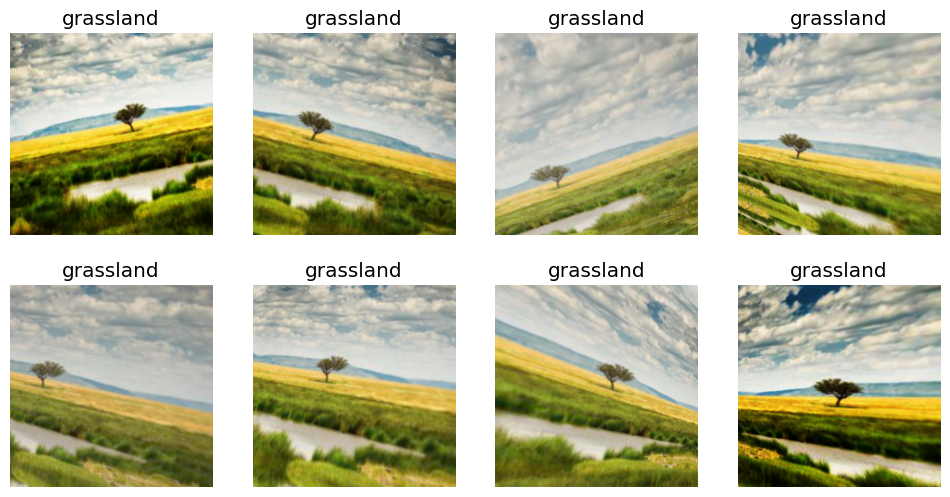

In [ ]:
# Adds data to a DataBlock
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[RandomResizedCrop(224, min_scale=0.5)],
    batch_tfms=aug_transforms(mult=2)
).dataloaders(path, bs=32)

#dls.show_batch(max_n=6)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Traning our model using the pretrained model resnet18

In [ ]:
# Trains Model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,2.099513,0.770406,0.225352,01:52


epoch,train_loss,valid_loss,error_rate,time
0,1.031846,0.580135,0.197183,02:35
1,0.876692,0.587244,0.161972,02:34
2,0.720781,0.584376,0.161972,02:35


## Part 3: Testing and revisions

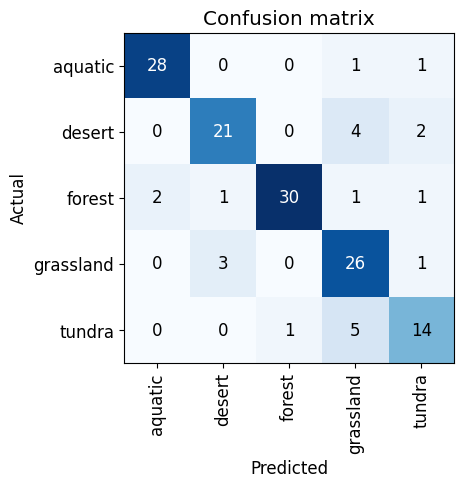

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
Looking at missed classifications

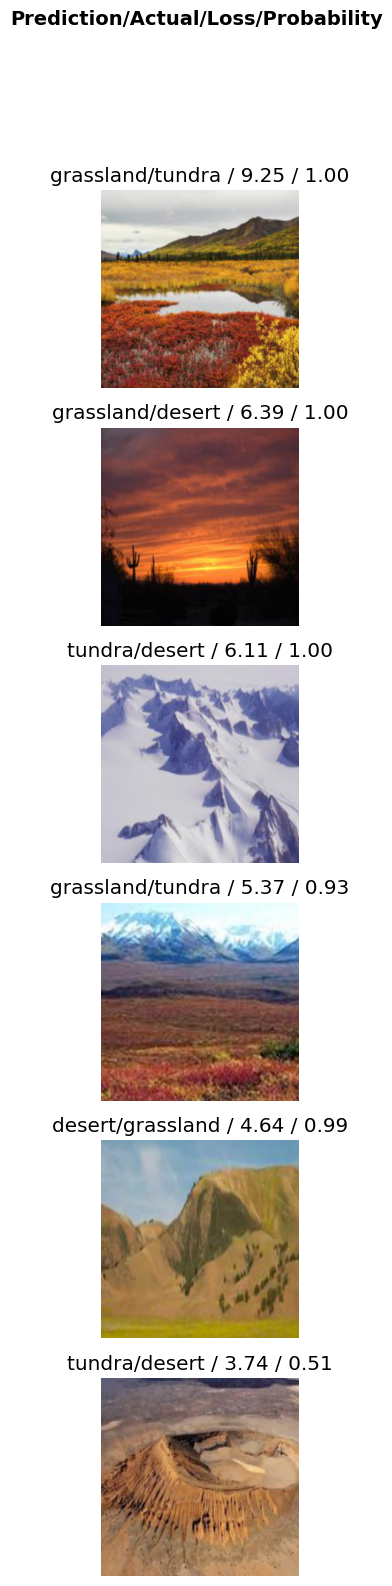

In [ ]:
interp.plot_top_losses(6, nrows=6)

Removing and reclassifying bad data points

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
# Makes necessary changes from cleaner
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
# Exports the model
learn.export('biomes_model.pkl')

##Part 5: Code for publishing the model to Gradio and Huggingface

In [ ]:
!pip install -Uqq gradio

from fastai.vision.all import *
import gradio as gr

In [ ]:
learn = load_learner('biomes_model.pkl')

In [ ]:
categories = ('aquatic', 'desert', 'forest', 'grassland', 'tundra')

def classify_image(img):
  pred,idx,probs = learn.predict(img)
  return dict(zip(categories, map(float,probs)))

In [ ]:
image = gr.inputs.Image(shape=(192,192))
label = gr.outputs.Label()
examples = ['forest.jpg', 'grassland.jpg', 'desert.jpg', 'aquatic.jpg', 'tundra.jpg']

intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)
intf.launch(inline=False, share=True)

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://d857aea69763ed2493.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


The published model can be accessed online here https://huggingface.co/spaces/JamesMartin/biomes_classifier